# Resampling Methods

Many times when using models in machine learning there isn't enough test data to accurately predict the test error. To fix this issue resampling methods are used to predict the test error from the training error.

## Validation Set

The easiest way of doing this is with a *validation set* or *holdout set* where we randomly select a set of instances to exclude from training. A model is then trained on the remaining instances and evaluated on the validation set. Afterwards the best model is trained on the entire training data.

In [ ]:
import sklearn
import numpy as np

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [54]:
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Now lets implement the validation test for 10% of the training data:

In [36]:
indices = np.random.permutation(X_train.shape[0])
training_idx, test_idx = indices[:6000], indices[6000:]
X_train_new, X_val = X_train[training_idx,:], X_train[test_idx,:]
y_train_new, y_val = np.ravel(y_train.reshape(-1,1)[training_idx,:]), np.ravel(y_train.reshape(-1,1)[test_idx,:])

In [37]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_new, y_train_new)
y_pred = sgd_clf.predict(X_val)

In [38]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)

0.8552222222222222

In [39]:
y_pred_test = sgd_clf.predict(X_test)
accuracy_score(y_test, y_pred_test)

0.8586

We got 85.2% accuracy on our validation set and 85.6% accuracy on the test set. Seems like the validation set measures test accuracy quite well!

## Leave-One-Out Cross-Validation (LOOCV)

LOOCV is quite similar to the validation set except now the validation set consists of only a single instance. This can be repeated for each instance in the training set and afterwards taking the average of the errors. However this is a computationally heavy process so below it is implemented with a smaller dataset of 100 instances:

In [93]:
X_train_LOOCV, y_train_LOOCV = X[:1000], y[:1000]

In [72]:
np.shape(np.vstack((X_train[:1], X_train[2:])))

(59999, 784)

In [94]:
errors = []
for i in range(len(X_train_LOOCV)):
    temp_X_train = np.vstack((X_train_LOOCV[:i],X_train_LOOCV[i+1:]))
    temp_y_train = np.hstack((y_train_LOOCV[:i], y_train_LOOCV[i+1:]))
    
    sgd_clf.fit(temp_X_train, temp_y_train)
    prediction = sgd_clf.predict([X_train_LOOCV[i]])
    errors.append((prediction-y_train_LOOCV[i])[0])

In [95]:
(len(errors)-np.count_nonzero(errors))/len(errors)

0.846

We got a 84.6% accuracy which is a great estimate considering only a 1000 instances were used for training.

## k-Fold Cross-Validation

K-fold cross validation is very similar to LOOCV except now we use $k$ different validation sets instead of $n$. The most common types are $k=10$ and $k=5$:

In [101]:
errors = []
for i in range(1,10):
    
    temp_X_train = np.vstack((X_train_LOOCV[:i*100],X_train_LOOCV[i*100+100:]))
    temp_y_train = np.hstack((y_train_LOOCV[:i*100], y_train_LOOCV[i*100+100:]))
    
    sgd_clf.fit(temp_X_train, temp_y_train)
    prediction = sgd_clf.predict(X_train[i*100:i*100+100])
    errors.append((100-(np.count_nonzero(prediction-y_train[i*100:i*100+100])))/100)

In [102]:
errors

[0.83, 0.83, 0.89, 0.84, 0.8, 0.8, 0.87, 0.81, 0.87]

Here we get a list of different errors for the the 10 validation sets. By analysing mean and standard deviations of this list we can also see how prone our model is to overfitting.

## The Bootstrap

The bootstrap essentially aims to calculate the confidence intervals or standard errors of data which has unknown distribution. It works by creating new data using a probability distribution given from the histograms of previous data. Here we can implement it below:

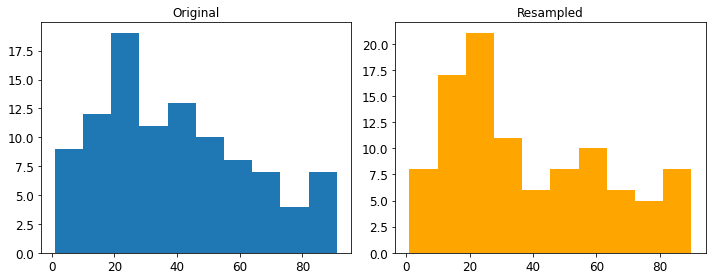

In [103]:
x = [1,1,2,3,3,5,7,8,9,10,
     10,11,11,13,13,15,16,17,18,18,
     18,19,20,21,21,23,24,24,25,25,
     25,25,26,26,26,27,27,27,27,27,
     29,30,30,31,33,34,34,34,35,36,
     36,37,37,38,38,39,40,41,41,42,
     43,44,45,45,46,47,48,48,49,50,
     51,52,53,54,55,55,56,57,58,60,
     61,63,64,65,66,68,70,71,72,74,
     75,77,81,83,84,87,89,90,90,91
     ]

import random
random.seed(42)
resampled_x = [random.choice(x) for i in range(100)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].hist(x, bins=10)
axes[0].set_title("Original")
axes[1].hist(resampled_x, bins=10, color="orange")
axes[1].set_title("Resampled")
fig.tight_layout()

plt.show()

In [104]:
print(sum(x)/len(x))
sum(resampled_x)/len(resampled_x)

39.26


38.49

The new mean was pretty close to the old mean. Now if we repeat this many times we will get a normal distribution of the means which can be used to estimate a standard error for the original data despite us not knowing the true distribution! This can be useful for estimating the standard error of predictions on the validation sets when not knowing the true distributions.